<a href="https://colab.research.google.com/github/asgharlaib/Project_v1/blob/main/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install --upgrade adapt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.9/100.9 kB 6.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 74.5 MB/s eta 0:00:00
  Created wheel for adapt: filename=adapt-0.4.4-py3-none-any.whl size=131790 sha256=63f3aa265e58236986d2e68282f182cbf2e9491662611bb22e13799b12412059
  Stored in directory: /root/.cache/pip/wheels/cb/88/91/f7ac7b6024ad8778b5ecca6ebe44421105722648f2a6b7afd7
Successfully built adapt
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.3.2
    Uninstalling scikit-learn-1.3.2:
      Successfully uninstalled scikit-learn-1.3.2


In [2]:
pip install keras --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 43.4 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1


In [3]:
!pip install prophet

In [84]:
#Importing necessary libraries
import pandas as pd
import scikeras
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, make_scorer
from sklearn.model_selection import GridSearchCV
from prophet import Prophet
from scikeras.wrappers import KerasRegressor
import os
from statsmodels.tsa.arima_model import ARIMA

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
#reading the dataset
full_df = pd.read_csv("/content/drive/MyDrive/LCL-June2015v2_134.csv")
full_df.head(n=10)

,LCLid,stdorToU,DateTime,KWH/hh (per half hour)
0,MAC005555,Std,2012-06-15 03:30:00.0000000,0.118
1,MAC005555,Std,2012-06-15 04:00:00.0000000,0.078
2,MAC005555,Std,2012-06-15 04:30:00.0000000,0.091
3,MAC005555,Std,2012-06-15 05:00:00.0000000,0.068
4,MAC005555,Std,2012-06-15 05:30:00.0000000,0.092
5,MAC005555,Std,2012-06-15 06:00:00.0000000,0.194
6,MAC005555,Std,2012-06-15 06:30:00.0000000,0.091
7,MAC005555,Std,2012-06-15 07:00:00.0000000,0.069
8,MAC005555,Std,2012-06-15 07:30:00.0000000,0.088
9,MAC005555,Std,2012-06-15 08:00:00.0000000,0.087


In [7]:
#Making copy of origonal dataset
full_df_copy = full_df.copy()

In [8]:
print(f"full_df columns datatypes: {full_df.dtypes}")

full_df columns datatypes: LCLid                      object
stdorToU                   object
DateTime                   object
KWH/hh (per half hour)     object
dtype: object


In [9]:
# Convert the 'DateTime' column to datetime type
full_df['DateTime'] = pd.to_datetime(full_df['DateTime'])


# Extract the date and time into separate columns
full_df['Date'] = full_df['DateTime'].dt.date
full_df['Time'] = full_df['DateTime'].dt.time


# Display the first few rows to verify
print(full_df.head())

       LCLid stdorToU            DateTime KWH/hh (per half hour)         Date  \
0  MAC005555      Std 2012-06-15 03:30:00                  0.118   2012-06-15   
1  MAC005555      Std 2012-06-15 04:00:00                  0.078   2012-06-15   
2  MAC005555      Std 2012-06-15 04:30:00                  0.091   2012-06-15   
3  MAC005555      Std 2012-06-15 05:00:00                  0.068   2012-06-15   
4  MAC005555      Std 2012-06-15 05:30:00                  0.092   2012-06-15   

       Time  
0  03:30:00  
1  04:00:00  
2  04:30:00  
3  05:00:00  
4  05:30:00  


In [10]:
full_df.set_index('DateTime', inplace=True)

In [11]:
#Converting consumption column to numeric datatype
full_df['KWH/hh (per half hour) '] = pd.to_numeric(full_df['KWH/hh (per half hour) '], errors='coerce')
full_df.columns

Index(['LCLid', 'stdorToU', 'KWH/hh (per half hour) ', 'Date', 'Time'], dtype='object')

In [12]:
#Pre-processing for creating daily dataframe
full_df_daily = full_df.groupby(['LCLid','stdorToU', 'Date']).agg({'KWH/hh (per half hour) ': 'sum'}).reset_index()
full_df_daily.rename(columns={'KWH/hh (per half hour) ': 'Daily KWH'}, inplace=True)
full_df_daily.head(20)

,LCLid,stdorToU,Date,Daily KWH
0,MAC000005,ToU,2012-06-01,2.866
1,MAC000005,ToU,2012-06-02,4.790
2,MAC000005,ToU,2012-06-03,5.447
3,MAC000005,ToU,2012-06-04,6.703
4,MAC000005,ToU,2012-06-05,5.056
5,MAC000005,ToU,2012-06-06,3.663
6,MAC000005,ToU,2012-06-07,3.863
7,MAC000005,ToU,2012-06-08,3.935
8,MAC000005,ToU,2012-06-09,2.612
9,MAC000005,ToU,2012-06-10,3.208


In [13]:
#Locating nan indices
nan_indices = full_df_daily[full_df_daily['Daily KWH'].isnull()].index
print(nan_indices)

Index([], dtype='int64')


In [13]:
#Dealing with nan values
full_df_daily['Daily KWH'].fillna(full_df_daily['Daily KWH'].mean(skipna=True), inplace=True)
full_df_daily.head(15)

,LCLid,stdorToU,Date,Daily KWH
0,MAC000005,ToU,2012-06-01,2.866
1,MAC000005,ToU,2012-06-02,4.790
2,MAC000005,ToU,2012-06-03,5.447
3,MAC000005,ToU,2012-06-04,6.703
4,MAC000005,ToU,2012-06-05,5.056
5,MAC000005,ToU,2012-06-06,3.663
6,MAC000005,ToU,2012-06-07,3.863
7,MAC000005,ToU,2012-06-08,3.935
8,MAC000005,ToU,2012-06-09,2.612
9,MAC000005,ToU,2012-06-10,3.208


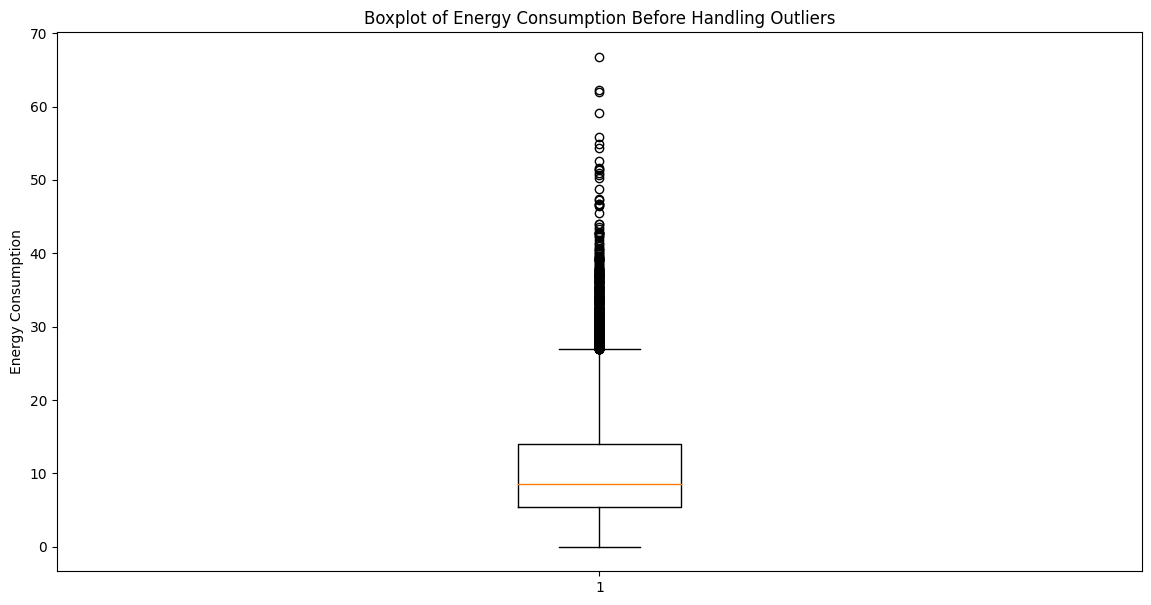

In [14]:
plt.figure(figsize=(14, 7))

plt.boxplot(full_df_daily['Daily KWH'])
plt.title('Boxplot of Energy Consumption Before Handling Outliers')
plt.ylabel('Energy Consumption')
plt.savefig('Outliers_Boxplot before.png')
plt.show()

In [15]:
quantile1 = full_df_daily['Daily KWH'].quantile(0.25)
quantile3 = full_df_daily['Daily KWH'].quantile(0.75)
Inter_quartile_range = quantile3 - quantile1
lower_bound = quantile1 - 1.5 * Inter_quartile_range
upper_bound = quantile3 + 1.5 * Inter_quartile_range

In [58]:
filtered_data = full_df_daily[(full_df_daily['Daily KWH'] >= lower_bound) &
                              (full_df_daily['Daily KWH'] <= upper_bound)]
filtered_data.head(-10)

,LCLid,stdorToU,Date,Daily KWH
0,MAC000005,ToU,2012-06-01,2.866
1,MAC000005,ToU,2012-06-02,4.790
2,MAC000005,ToU,2012-06-03,5.447
3,MAC000005,ToU,2012-06-04,6.703
4,MAC000005,ToU,2012-06-05,5.056
...,...,...,...,...
20861,MAC005567,Std,2014-02-14,5.364
20862,MAC005567,Std,2014-02-15,7.075
20863,MAC005567,Std,2014-02-16,6.727
20864,MAC005567,Std,2014-02-17,6.593


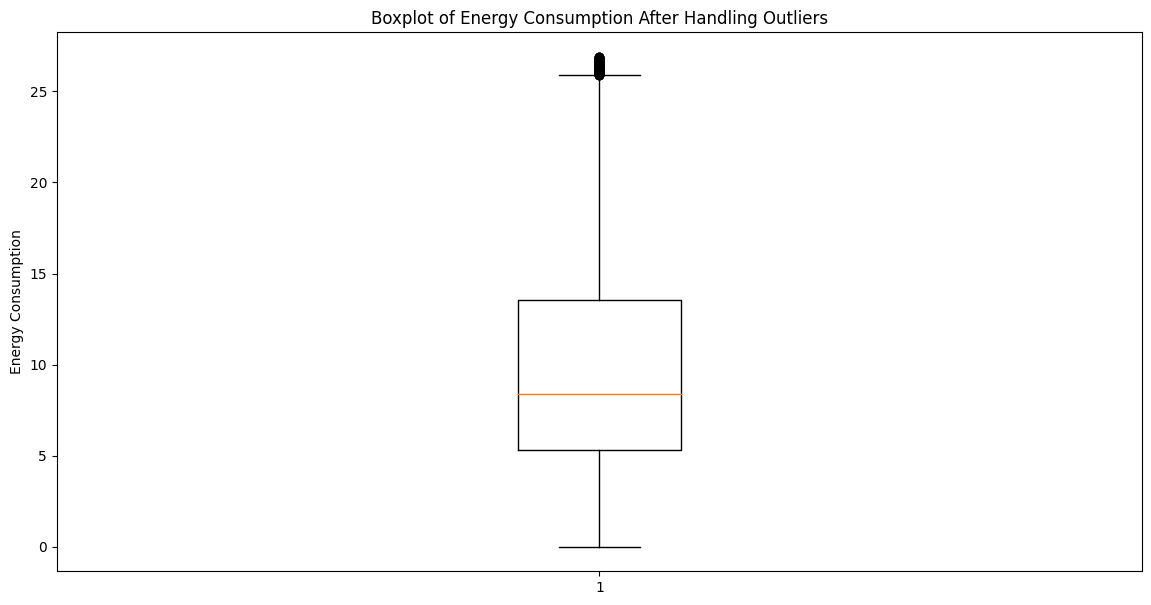

In [17]:
plt.figure(figsize=(14, 7))

plt.boxplot(filtered_data['Daily KWH'])
plt.title('Boxplot of Energy Consumption After Handling Outliers')
plt.ylabel('Energy Consumption')
plt.savefig('Outliers_Subplot after.png')
plt.show()



In [18]:
#Looking for missing values
print(f"missing values: {full_df_daily.isnull().sum()} \n")

missing values: LCLid        0
stdorToU     0
Date         0
Daily KWH    0
dtype: int64 



In [19]:
##Descriptive Analysis
#Dataframe column names
print(f"Column names: {list(full_df_daily.columns)} \n")

#Dataframe shape
print(f"full_df_daily shape: {full_df_daily.shape} \n")

#Dataframe datatypes
print(f"full_df_daily columns datatypes: {full_df_daily.dtypes} \n")

#Looking for missing values
print(f"missing values: {full_df_daily.isnull().sum()} \n")

Column names: ['LCLid', 'stdorToU', 'Date', 'Daily KWH'] 

full_df_daily shape: (20876, 4) 

full_df_daily columns datatypes: LCLid         object
stdorToU      object
Date          object
Daily KWH    float64
dtype: object 

missing values: LCLid        0
stdorToU     0
Date         0
Daily KWH    0
dtype: int64 



In [20]:
##Descriptive Statistics
full_df_daily.describe()

,Daily KWH
count,20876.000000
mean,10.420657
std,6.714300
min,0.000000
25%,5.385000
50%,8.580000
75%,13.991000
max,66.782000


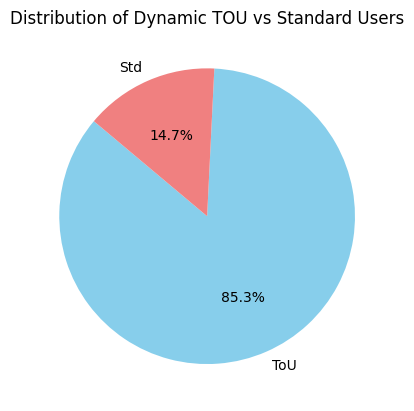

In [21]:
# Count the occurrences of each category
counts = filtered_data['stdorToU'].value_counts()

# Plot a pie chart
plt.figure()
plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=140, colors=['skyblue', 'lightcoral'])
plt.title('Distribution of Dynamic TOU vs Standard Users')
plt.show()


           LCLid stdorToU        Date  Daily KWH
17764  MAC005555      Std  2012-06-15      4.251
17765  MAC005555      Std  2012-06-16      5.190
17766  MAC005555      Std  2012-06-17      4.720
17767  MAC005555      Std  2012-06-18      6.311
17768  MAC005555      Std  2012-06-19      5.720
       LCLid stdorToU        Date  Daily KWH
0  MAC000005      ToU  2012-06-01      2.866
1  MAC000005      ToU  2012-06-02      4.790
2  MAC000005      ToU  2012-06-03      5.447
3  MAC000005      ToU  2012-06-04      6.703
4  MAC000005      ToU  2012-06-05      5.056


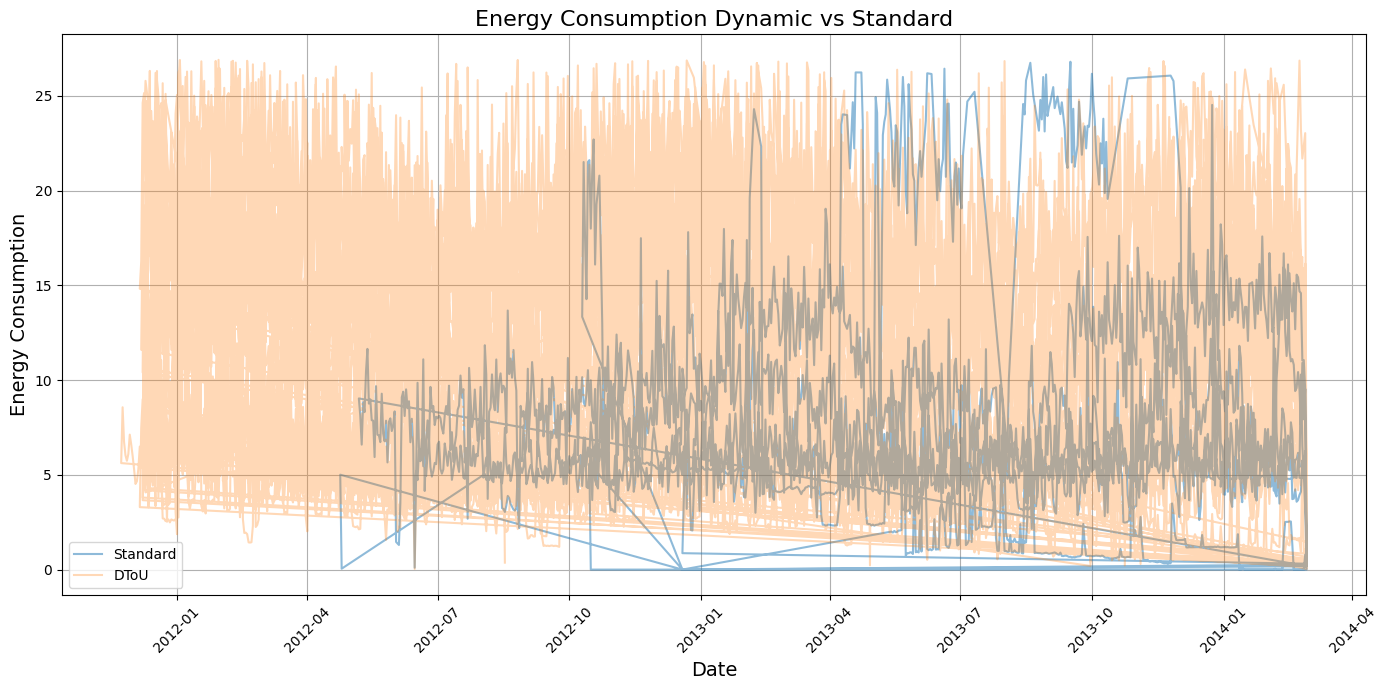

In [59]:
# Filter for dynamic and standard pricing
df_standard = filtered_data[filtered_data['stdorToU'] == 'Std']
df_dynamic = filtered_data[filtered_data['stdorToU'] == 'ToU']

print(df_standard.head())
print(df_dynamic.head())
# Plot the data
plt.figure(figsize=(14, 7))
#plt.hist(df_dynamic['KWH/hh (per half hour) '], bins=20, alpha=0.5, color = 'b', label='Dynamic')
#plt.hist(df_standard['KWH/hh (per half hour) '], bins=20, alpha=0.5, color = 'r', label='Standard')
plt.plot(df_standard['Date'], df_standard['Daily KWH'],alpha = 0.5, label='Standard')
plt.plot(df_dynamic['Date'], df_dynamic['Daily KWH'],alpha= 0.3, label='DToU')
# Formatting the plot
plt.title('Energy Consumption Dynamic vs Standard', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Energy Consumption', fontsize=14)
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()


In [60]:
def preprocess_data(df, time_step):
    data = df['Daily KWH'].values
    dates = df['Date'].values  # Using 'Date' column
    data = data.reshape(-1, 1)
    scaler = MinMaxScaler(feature_range=(0, 1))
    data = scaler.fit_transform(data)

    X, y, datestamps = [], [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
        datestamps.append(dates[i + time_step])  # Store corresponding date
    X = np.array(X)
    y = np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    datestamps = np.array(datestamps)  # Convert list to numpy array
    return X, y, scaler, datestamps


In [61]:
# Check for NaNs in the input data for the standard users
if df_standard.isnull().values.any():
    print("NaN values found in the input data for standard users.")
else:
    print("No NaN values in the input data for standard users.")


No NaN values in the input data for standard users.


In [62]:
# Preprocess the data
time_step = 8  # number of previous timesteps to use for prediction
X_dynamic, y_dynamic, scaler_dynamic, date_stamps_dynamic = preprocess_data(df_dynamic, time_step)
X_standard, y_standard, scaler_standard, date_stamps_standard = preprocess_data(df_standard, time_step)

# Split the data into training and testing sets
X_train_dyn, X_test_dyn, y_train_dyn, y_test_dyn = train_test_split(X_dynamic, y_dynamic, test_size=0.2, random_state=42)
X_train_std, X_test_std, y_train_std, y_test_std = train_test_split(X_standard, y_standard, test_size=0.2, random_state=42)

In [63]:
# Build LSTM model
def build_lstm_model(input_shape, units=50, dropout_rate=0.2, learning_rate=0.001):
    print(f"Building LSTM model with input shape: {input_shape}")
    model = Sequential()
    model.add(LSTM(units, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units, return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mean_squared_error')
    return model


In [64]:
# Train the LSTM model for dynamic users
model_dynamic = build_lstm_model(input_shape=(X_train_dyn.shape[1], X_train_dyn.shape[2]))
history_dynamic = model_dynamic.fit(X_train_dyn, y_train_dyn, epochs=20, batch_size=32, validation_data=(X_test_dyn, y_test_dyn), verbose=1)


Building LSTM model with input shape: (8, 1)
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0242 - val_loss: 0.0135
Epoch 2/20
435/435 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0135 - val_loss: 0.0131
Epoch 3/20
435/435 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0142 - val_loss: 0.0129
Epoch 4/20
435/435 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0133 - val_loss: 0.0127
Epoch 5/20
435/435 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0136 - val_loss: 0.0127
Epoch 6/20
435/435 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0137 - val_loss: 0.0135
Epoch 7/20
435/435 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0135 - val_loss: 0.0124
Epoch 8/20
435/435 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0131 - val_loss: 0.0128
Epoch 9/20
435/435 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0132 - val_loss: 0.0127
Epoch 10/20
435/435 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0133 - val_loss: 0.0126
Epoch 11/20
435/435 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0130 - val_loss: 0.0125
Epoch 12/20
435/435 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.

In [65]:
# Train the LSTM model for standard users
model_standard = build_lstm_model(input_shape=(X_train_std.shape[1], X_train_std.shape[2]))
history_standard = model_standard.fit(X_train_std, y_train_std, epochs=20, batch_size=32, validation_data=(X_test_std, y_test_std), verbose=1)


Building LSTM model with input shape: (8, 1)
Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0306 - val_loss: 0.0075
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0086 - val_loss: 0.0069
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0104 - val_loss: 0.0068
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0088 - val_loss: 0.0079
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0083 - val_loss: 0.0062
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0100 - val_loss: 0.0059
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0085 - val_loss: 0.0056
Epoch 8/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0079 - val_loss: 0.0076
Epoch 9/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0080 - val_loss: 0.0056
Epoch 10/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0080 - val_loss: 0.0053
Epoch 11/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0070 - val_loss: 0.0052
Epoch 12/20
75/75 ━━━━━━━━━━━

In [66]:
# Predict consumption for dynamic users
pred_dynamic = model_dynamic.predict(X_test_dyn)

# Predict consumption for standard users
pred_standard = model_standard.predict(X_test_std)

109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


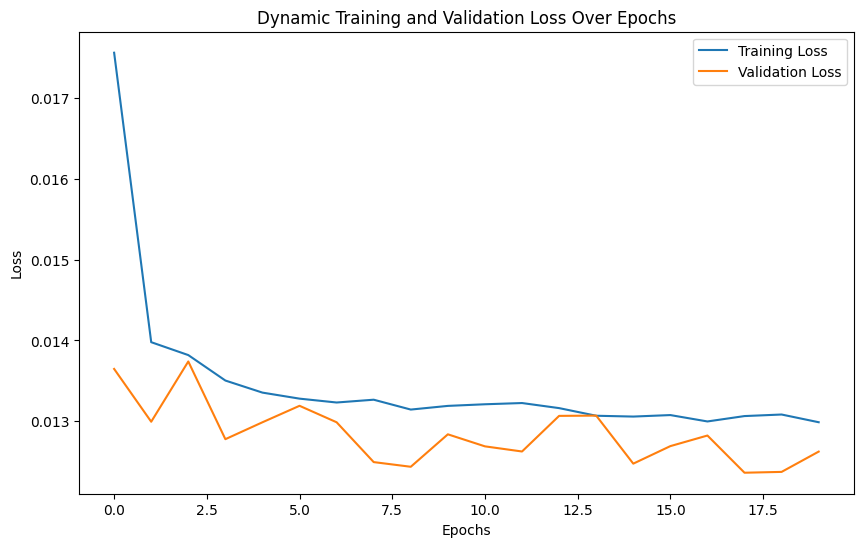

In [34]:
# Plotting the training and validation loss
plt.figure(figsize=(10, 6))

# Plot the training loss
plt.plot(history_dynamic.history['loss'], label='Training Loss')

# Plot the validation loss
plt.plot(history_dynamic.history['val_loss'], label='Validation Loss')

# Add a title and labels
plt.title('Dynamic Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Show the legend
plt.legend()

# Display the plot
plt.show()


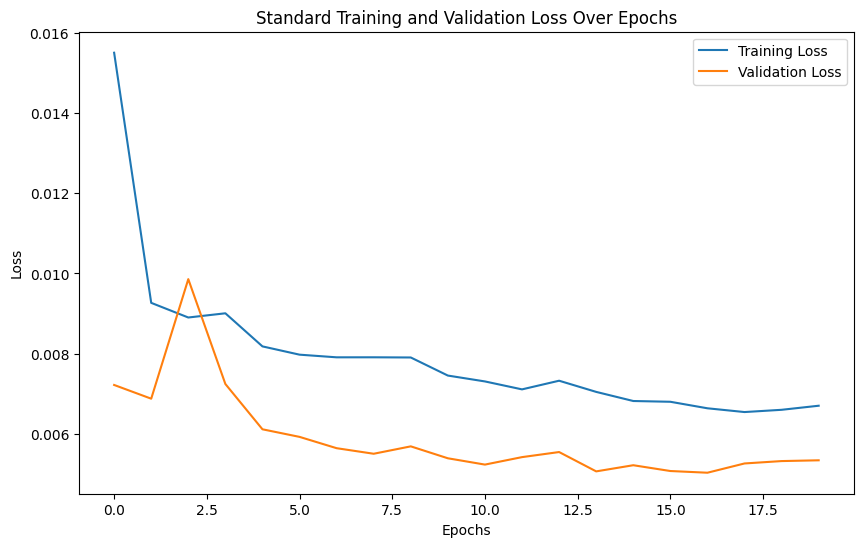

In [33]:
import matplotlib.pyplot as plt

# Plotting the training and validation loss
plt.figure(figsize=(10, 6))

# Plot the training loss
plt.plot(history_standard.history['loss'], label='Training Loss')

# Plot the validation loss
plt.plot(history_standard.history['val_loss'], label='Validation Loss')

# Add a title and labels
plt.title('Standard Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Show the legend
plt.legend()

# Display the plot
plt.show()


In [67]:
# Check for NaNs in the predictions
if np.any(np.isnan(pred_standard)):
    print("NaN values found in standard predictions.")
else:
    print("No NaN values in standard predictions.")


No NaN values in standard TOU predictions.


In [68]:
# Inverse transform the predictions for dynamic users
pred_dynamic = scaler_dynamic.inverse_transform(pred_dynamic)
y_test_dyn_inverse = scaler_dynamic.inverse_transform(y_test_dyn.reshape(-1, 1))

# Inverse transform the predictions for standard users
pred_standard = scaler_standard.inverse_transform(pred_standard)
y_test_std_inverse = scaler_standard.inverse_transform(y_test_std.reshape(-1, 1))

In [70]:
# Calculate MAE for dynamic users
mae_dynamic = mean_absolute_error(y_test_dyn_inverse, pred_dynamic)
mse_dynamic = mean_squared_error(y_test_dyn_inverse, pred_dynamic)
rmse_dynamic = np.sqrt(mse_dynamic)
mape_dynamic = mean_absolute_percentage_error(y_test_dyn_inverse, pred_dynamic)

print(f"Dynamic TOU MAE: {mae_dynamic}")
print(f"Dynamic TOU MSE: {mse_dynamic}")
print(f"Dynamic TOU RMSE: {rmse_dynamic}")
print(f"Dynamic TOU MAPE: {mape_dynamic}")

# Calculate MAE for standard users
mae_standard = mean_absolute_error(y_test_std_inverse, pred_standard)
mse_standard = mean_squared_error(y_test_std_inverse, pred_standard)
rmse_standard = np.sqrt(mse_standard)
mape_standard = mean_absolute_percentage_error(y_test_std_inverse, pred_standard)

print(f"Standard TOU MAE: {mae_standard}")
print(f"Standard TOU MSE: {mse_standard}")
print(f"Standard TOU RMSE: {rmse_standard}")
print(f"Standard TOU MAPE: {mape_standard}")


Dynamic TOU MAE: 2.1359400967314324
Dynamic TOU MSE: 8.956179057181982
Dynamic TOU RMSE: 2.9926875976589975
Dynamic TOU MAPE: 0.296663927246773
Standard TOU MAE: 1.305516198783685
Standard TOU MSE: 3.652103679003246
Standard TOU RMSE: 1.9110477961064307
Standard TOU MAPE: 43374626104230.97


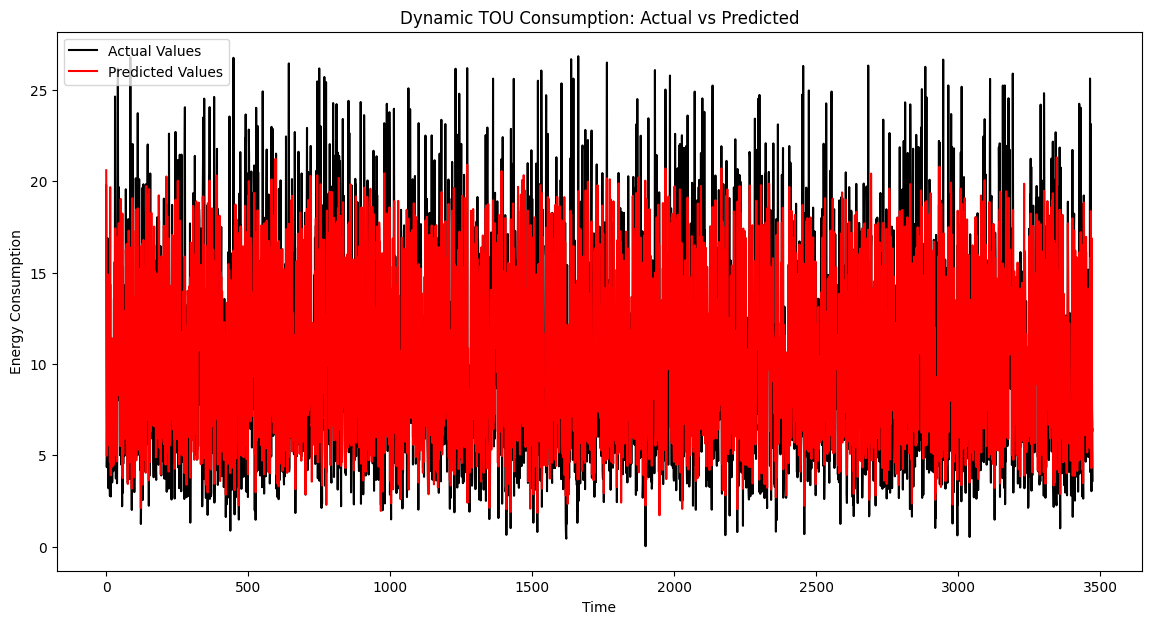

In [71]:
# Plot the predictions vs actual values for dynamic TOU users
plt.figure(figsize=(14, 7))
plt.plot(y_test_dyn_inverse, color='black', label='Actual Values')
plt.plot(pred_dynamic, color='red', label='Predicted Values')
plt.title('Dynamic TOU Consumption: Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Energy Consumption')
plt.legend()
plt.show()




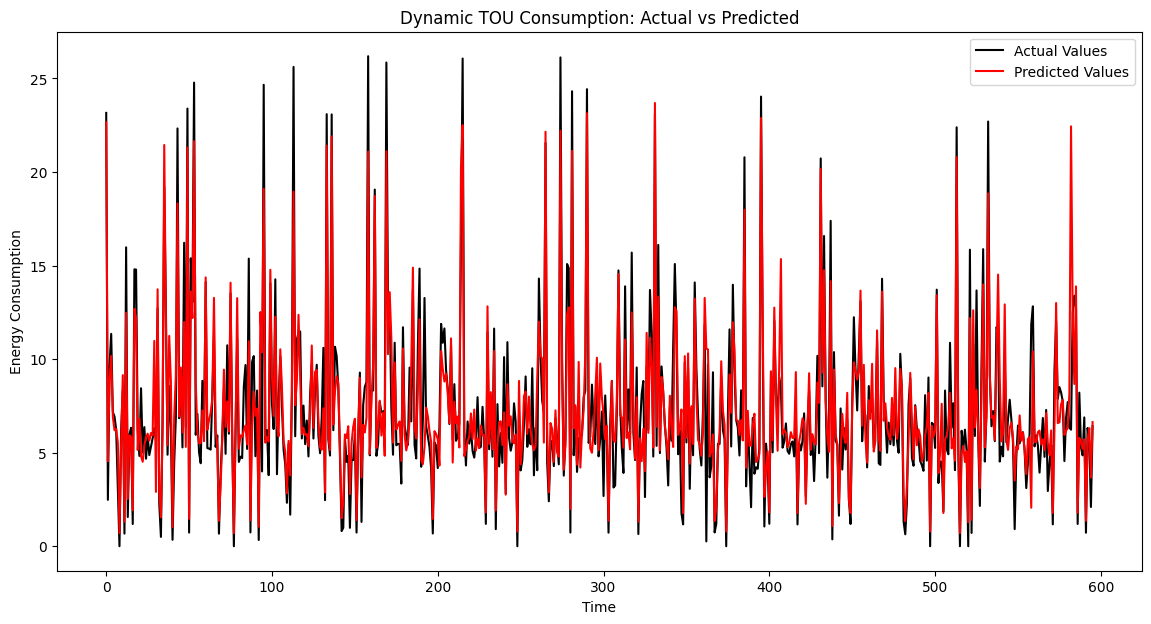

In [72]:
# Plot the predictions vs actual values for dynamic TOU users
plt.figure(figsize=(14, 7))
plt.plot(y_test_std_inverse, color='black', label='Actual Values')
plt.plot(pred_standard, color='red', label='Predicted Values')
plt.title('Dynamic TOU Consumption: Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Energy Consumption')
plt.legend()
plt.show()


In [73]:
model = KerasRegressor(build_fn=build_lstm_model, input_shape = (8,1), epochs=1, batch_size=32, verbose=0, dropout_rate=0.2, learning_rate=0.001, units=50)

In [85]:
param_grid = {
    'units': [50, 100],
    'dropout_rate': [0.2, 0.3],
    'learning_rate': [0.001, 0.01],
    'batch_size': [32, 64],
    'epochs': [10, 20]
}

from sklearn.model_selection import GridSearchCV

grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, scoring='neg_mean_absolute_error')
grid_result = grid.fit(X_train_dyn, y_train_dyn)

# Print the best parameters and score
print(f"Best parameters found: {grid_result.best_params_}")
print(f"Best score found: {grid_result.best_score_}")


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Building LSTM model with input shape: (8, 1)
Best parameters found: {'batch_size': 32, 'dropout_rate': 0.3, 'epochs': 20, 'learning_rate': 0.001, 'units': 50}
Best score found: -0.07849103622259178


In [86]:
# Build LSTM model
def best_grid_lstm_model(input_shape, units=50, dropout_rate=0.3, learning_rate=0.001):
    print(f"Building LSTM model with input shape: {input_shape}")
    model = Sequential()
    model.add(LSTM(units, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units, return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mean_squared_error')
    return model

In [87]:
best_model_dynamic = best_grid_lstm_model(input_shape=(X_train_dyn.shape[1], X_train_dyn.shape[2]))
history_best_dynamic = best_model_dynamic.fit(X_train_dyn, y_train_dyn, epochs=20, batch_size=32, validation_data=(X_test_dyn, y_test_dyn), verbose=1)

Building LSTM model with input shape: (8, 1)
Epoch 1/20
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0285 - val_loss: 0.0134
Epoch 2/20
435/435 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0143 - val_loss: 0.0131
Epoch 3/20
435/435 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0140 - val_loss: 0.0131
Epoch 4/20
435/435 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0140 - val_loss: 0.0130
Epoch 5/20
435/435 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0134 - val_loss: 0.0136
Epoch 6/20
435/435 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0133 - val_loss: 0.0126
Epoch 7/20
435/435 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0134 - val_loss: 0.0129
Epoch 8/20
435/435 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0135 - val_loss: 0.0126
Epoch 9/20
435/435 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0136 - val_loss: 0.0126
Epoch 10/20
435/435 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0130 - val_loss: 0.0126
Epoch 11/20
435/435 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0129 - val_loss: 0.0125
Epoch 1

In [88]:
best_model_standard = best_grid_lstm_model(input_shape=(X_train_std.shape[1], X_train_std.shape[2]))
history_best_standard = best_model_standard.fit(X_train_std, y_train_std, epochs=20, batch_size=32, validation_data=(X_test_std, y_test_std), verbose=1)

Building LSTM model with input shape: (8, 1)
Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0224 - val_loss: 0.0070
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0108 - val_loss: 0.0079
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0097 - val_loss: 0.0062
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0086 - val_loss: 0.0062
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0080 - val_loss: 0.0060
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0080 - val_loss: 0.0058
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0077 - val_loss: 0.0057
Epoch 8/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0076 - val_loss: 0.0057
Epoch 9/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0078 - val_loss: 0.0056
Epoch 10/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0078 - val_loss: 0.0053
Epoch 11/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0078 - val_loss: 0.0053
Epoch 12/20
75/75 ━━━━━━━━━━━

In [89]:
# Predict consumption for dynamic users
pred_dynamic1 = best_model_dynamic.predict(X_test_dyn)

# Predict consumption for standard users
pred_standard1 = best_model_standard.predict(X_test_std)

109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


In [90]:
# Inverse transform the predictions for dynamic users
pred_dynamic1 = scaler_dynamic.inverse_transform(pred_dynamic1)
y_test_dyn_inverse = scaler_dynamic.inverse_transform(y_test_dyn.reshape(-1, 1))

# Inverse transform the predictions for standard users
pred_standard1 = scaler_standard.inverse_transform(pred_standard1)
y_test_std_inverse = scaler_standard.inverse_transform(y_test_std.reshape(-1, 1))

In [91]:
# Find peak consumption values for dynamic users
peak_dynamic_value = max(pred_dynamic)
print(f"Peak Dynamic TOU Consumption Value: {peak_dynamic_value}")
# Find peak consumption values for standard users
peak_standard_value = max(pred_standard)
print(f"Peak Standard Consumption Value: {peak_standard_value}")

Peak Dynamic TOU Consumption Value: [21.31035]
Peak Standard Consumption Value: [23.688377]


In [92]:
# Calculate MAE for dynamic users
mae_dynamic_opt = mean_absolute_error(y_test_dyn_inverse, pred_dynamic1)
mse_dynamic_opt = mean_squared_error(y_test_dyn_inverse, pred_dynamic1)
rmse_dynamic_opt = np.sqrt(mse_dynamic_opt)
mape_dynamic_opt = mean_absolute_percentage_error(y_test_dyn_inverse, pred_dynamic1)

print(f"Optimized Dynamic TOU MAE: {mae_dynamic_opt}")
print(f"Optimized Dynamic TOU MSE: {mse_dynamic_opt}")
print(f"Optimized Dynamic TOU RMSE: {rmse_dynamic_opt}")
print(f"Optimized Dynamic TOU MAPE: {mape_dynamic_opt}")

# Calculate MAE for standard users
mae_standard_opt = mean_absolute_error(y_test_std_inverse, pred_standard1)
mse_standard_opt = mean_squared_error(y_test_std_inverse, pred_standard1)
rmse_standard_opt = np.sqrt(mse_standard_opt)
mape_standard_opt = mean_absolute_percentage_error(y_test_std_inverse, pred_standard1)

print(f"Optimized Standard TOU MAE: {mae_standard_opt}")
print(f"Optimized Standard TOU MSE: {mse_standard_opt}")
print(f"Optimized Standard TOU RMSE: {rmse_standard_opt}")
print(f"Optimized Standard TOU MAPE: {mape_standard_opt}")


Optimized Dynamic TOU MAE: 2.118974279321877
Optimized Dynamic TOU MSE: 9.489666779542643
Optimized Dynamic TOU RMSE: 3.0805302757062205
Optimized Dynamic TOU MAPE: 0.2718751067908935
Optimized Standard TOU MAE: 1.261382352920359
Optimized Standard TOU MSE: 3.5893613085503793
Optimized Standard TOU RMSE: 1.8945609804253807
Optimized Standard TOU MAPE: 26625079899569.258


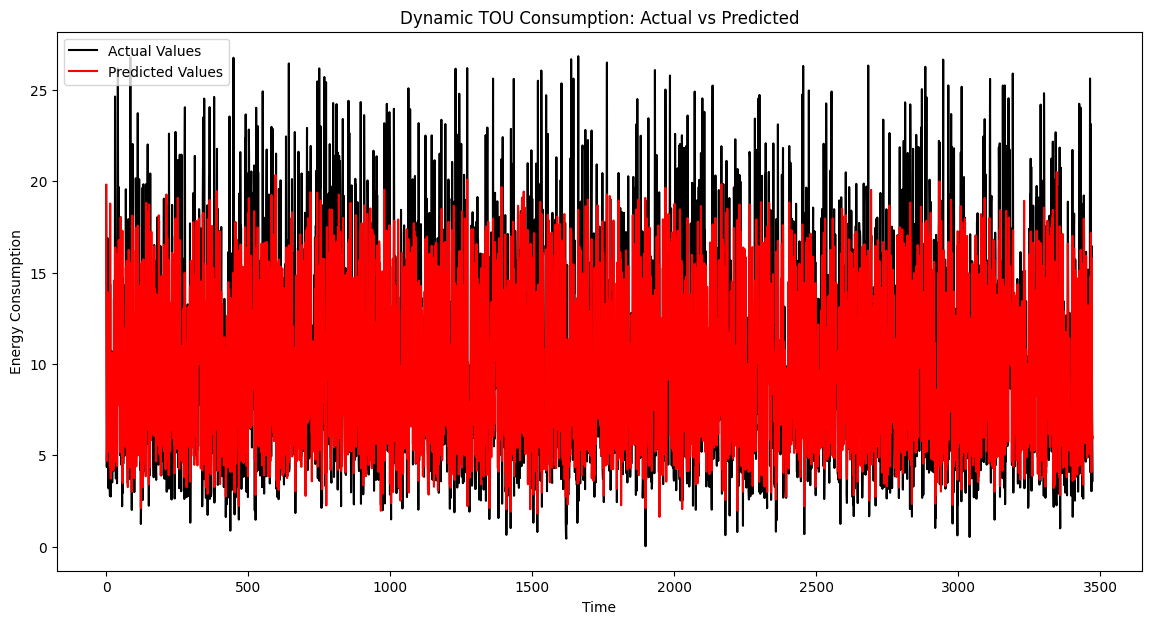

In [93]:
# Plot the predictions vs actual values for dynamic TOU users
plt.figure(figsize=(14, 7))
plt.plot(y_test_dyn_inverse, color='black', label='Actual Values')
plt.plot(pred_dynamic1, color='red', label='Predicted Values')
plt.title('Dynamic TOU Consumption: Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Energy Consumption')
plt.legend()
plt.show()

In [96]:
df_prophet_dynamic = df_dynamic[['Date', 'Daily KWH']].rename(columns={'Date': 'ds', 'Daily KWH': 'y'})

In [97]:
train_size_dynamic = int(len(df_prophet_dynamic) * 0.8)
train_data_dynamic = df_prophet_dynamic[:train_size_dynamic]
test_data_dynamic = df_prophet_dynamic[train_size_dynamic:]

In [98]:
model_dynamic = Prophet()
model_dynamic.fit(train_data_dynamic)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp55rp_vzb/l6pznsh3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp55rp_vzb/pwx0eqau.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12636', 'data', 'file=/tmp/tmp55rp_vzb/l6pznsh3.json', 'init=/tmp/tmp55rp_vzb/pwx0eqau.json', 'output', 'file=/tmp/tmp55rp_vzb/prophet_model8xg6dlo1/prophet_model-20240826113332.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:33:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:33:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [99]:
future_dynamic = model_dynamic.make_future_dataframe(periods=len(test_data_dynamic), freq='D')  # 'H' for hourly data
forecast_dynamic = model_dynamic.predict(future_dynamic)

In [101]:
forecast_test_dynamic = forecast_dynamic.iloc[-len(test_data_dynamic):]['yhat']
mse_dynamic = mean_squared_error(test_data_dynamic['y'], forecast_test_dynamic)
mae_dynamic = mean_absolute_error(test_data_dynamic['y'], forecast_test_dynamic)
rmse_dynamic = np.sqrt(mse_dynamic)
mape_dynamic = mean_absolute_percentage_error(test_data_dynamic['y'], forecast_test_dynamic)



print(f'Mean Squared Error: {mse_dynamic}')
print(f'Mean Absolute Error: {mae_dynamic}')
print(f'Root Mean Squared Error: {rmse_dynamic}')
print(f'Mean Absolute Percentage Error: {mape_dynamic}')

Mean Squared Error: 42.49192582764587
Mean Absolute Error: 4.832607030276668
Root Mean Squared Error: 6.51858311503703
Mean Absolute Percentage Error: 0.5141912412255243


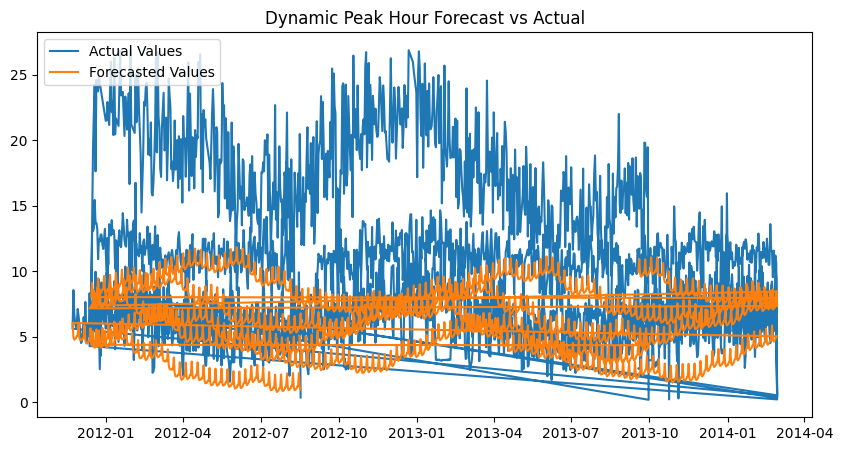

In [102]:
plt.figure(figsize=(10, 5))
plt.plot(test_data_dynamic['ds'], test_data_dynamic['y'], label='Actual Values')
plt.plot(test_data_dynamic['ds'], forecast_test_dynamic, label='Forecasted Values')
plt.legend(loc='upper left')
plt.title('Dynamic Peak Hour Forecast vs Actual')
plt.show()

In [104]:
df_prophet_std = df_standard[['Date', 'Daily KWH']].rename(columns={'Date': 'ds', 'Daily KWH': 'y'})

In [105]:
train_size_std = int(len(df_prophet_std) * 0.8)
train_data_std = df_prophet_std[:train_size_std]
test_data_std = df_prophet_std[train_size_std:]
print(test_data_std)

               ds       y
20184  2013-06-19  21.663
20185  2013-06-20  26.429
20186  2013-06-21  20.722
20187  2013-06-22  24.570
20188  2013-06-23  24.588
...           ...     ...
20871  2014-02-24   4.107
20872  2014-02-25   5.762
20873  2014-02-26   5.066
20874  2014-02-27   3.217
20875  2014-02-28   0.366

[598 rows x 2 columns]


In [106]:
model_std = Prophet()
model_std.fit(train_data_std)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp55rp_vzb/b9u4ouk6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp55rp_vzb/9p1_cylr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77249', 'data', 'file=/tmp/tmp55rp_vzb/b9u4ouk6.json', 'init=/tmp/tmp55rp_vzb/9p1_cylr.json', 'output', 'file=/tmp/tmp55rp_vzb/prophet_model76pih1oc/prophet_model-20240826113930.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:39:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:39:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [107]:
test_data_std = test_data_std.dropna(subset=['y'])

In [108]:
test_data_std['y'].fillna(method='ffill', inplace=True)  # forward fill

<ipython-input-108-283958d955af>:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test_data_std['y'].fillna(method='ffill', inplace=True)  # forward fill


In [109]:
print(test_data_std[test_data_std['y'].isna()])

Empty DataFrame
Columns: [ds, y]
Index: []


In [110]:
future_std = model_std.make_future_dataframe(periods=len(test_data_std), freq='D')  # 'H' for hourly data
forecast_std = model_std.predict(future_std)

In [111]:
forecast_test_std = forecast_std.iloc[-len(test_data_std):]['yhat']

mse_std = mean_squared_error(test_data_std['y'], forecast_test_std)
mae_std = mean_absolute_error(test_data_std['y'], forecast_test_std)
rmse_std = np.sqrt(mse_std)
mape_std = mean_absolute_percentage_error(test_data_std['y'], forecast_test_std)



print(f'Mean Squared Error: {mse_std}')
print(f'Mean Absolute Error: {mae_std}')
print(f'Root Mean Squared Error: {rmse_std}')
print(f'Mean Absolute Percentage Error: {mape_std}')

Mean Squared Error: 58.52660518410831
Mean Absolute Error: 6.681225940320475
Root Mean Squared Error: 7.650268307981643
Mean Absolute Percentage Error: 1.3188474741262088


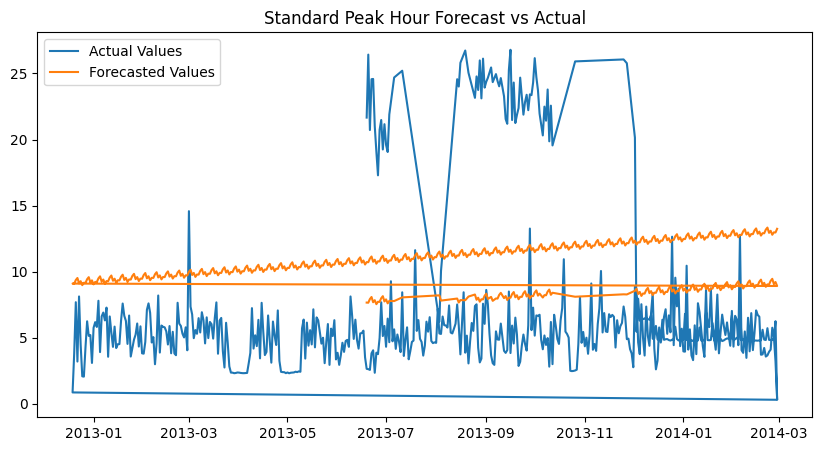

In [112]:
plt.figure(figsize=(10, 5))
plt.plot(test_data_std['ds'], test_data_std['y'], label='Actual Values')
plt.plot(test_data_std['ds'], forecast_test_std, label='Forecasted Values')
plt.legend(loc='upper left')
plt.title('Standard Peak Hour Forecast vs Actual')
plt.show()

In [113]:
# Find the maximum predicted consumption
max_predicted_value = forecast_dynamic['yhat'].max()
# Find the maximum predicted consumption
max_predicted_value = forecast_std['yhat'].max()

# Print the results
print(f"The maximum predicted dynamic consumption is {max_predicted_value:.2f} KWH")
print(f"The maximum predicted standard consumption is {max_predicted_value:.2f} KWH")

The maximum predicted dynamic consumption is 13.34 KWH
The maximum predicted standard consumption is 13.34 KWH


In [117]:
import itertools

# Define the parameter grid
param_grid = {
    'changepoint_prior_scale': [0.01, 0.1, 0.5],
    'seasonality_prior_scale': [10.0, 15.0, 20.0],
    'holidays_prior_scale': [0.1, 0.5, 1.0]
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]

# Initialize a DataFrame to store the results
results = []

# Loop over each combination of parameters
for params in all_params:
    # Initialize a Prophet model with the current set of parameters
    model = Prophet(
        changepoint_prior_scale=params['changepoint_prior_scale'],
        seasonality_prior_scale=params['seasonality_prior_scale'],
        holidays_prior_scale=params['holidays_prior_scale'],
        daily_seasonality=True,
        yearly_seasonality=True,
        weekly_seasonality=True
    )

     # Fit the model on the training data
    model.fit(train_data_dynamic)

    # Make predictions on the test data
    forecast = model.predict(test_data_dynamic)

    # Calculate the mean squared error of the predictions
    mse = mean_squared_error(test_data_dynamic['y'], forecast['yhat'])

    # Store the parameters and the mse in the results list
    results.append({'params': params, 'mse': mse})

# Convert the results list into a DataFrame
results_df = pd.DataFrame(results)

# Find the parameters with the lowest mse
best_params = results_df.loc[results_df['mse'].idxmin()]

print(f"Best Parameters: {best_params['params']}")
print(f"Best MSE: {best_params['mse']}")

DEBUG:cmdstanpy:input tempfile: /tmp/tmp55rp_vzb/ieyhrgcq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp55rp_vzb/jer7n88h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77814', 'data', 'file=/tmp/tmp55rp_vzb/ieyhrgcq.json', 'init=/tmp/tmp55rp_vzb/jer7n88h.json', 'output', 'file=/tmp/tmp55rp_vzb/prophet_modellx6tcd2c/prophet_model-20240826115214.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:52:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:52:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp55rp_vzb/3oci7pm1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp55rp_vzb/prof1jvz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Best Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1}
Best MSE: 27.299215816034295


In [118]:
#Define the parameter grid
param_grid = {
    'changepoint_prior_scale': [0.01, 0.1, 0.5],
    'seasonality_prior_scale': [10.0, 15.0, 20.0],
    'holidays_prior_scale': [0.1, 0.5, 1.0],
    'yearly_seasonality': [True, False]
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]

# Initialize a DataFrame to store the results
results = []

# Loop over each combination of parameters
for params in all_params:
    # Initialize a Prophet model with the current set of parameters
    model = Prophet(
        changepoint_prior_scale=params['changepoint_prior_scale'],
        seasonality_prior_scale=params['seasonality_prior_scale'],
        holidays_prior_scale=params['holidays_prior_scale'],
        yearly_seasonality=params['yearly_seasonality'],
        daily_seasonality=True,
        weekly_seasonality=True

    )

    # Fit the model on the training data
    model.fit(train_data_dynamic)

    # Make predictions on the test data
    forecast = model.predict(test_data_dynamic)

    # Calculate the mean squared error of the predictions
    mse = mean_squared_error(test_data_dynamic['y'], forecast['yhat'])

    # Store the parameters and the mse in the results list
    results.append({'params': params, 'mse': mse})

# Convert the results list into a DataFrame
results_df = pd.DataFrame(results)

# Find the parameters with the lowest mse
best_params = results_df.loc[results_df['mse'].idxmin()]

print(f"Best Parameters: {best_params['params']}")
print(f"Best MSE: {best_params['mse']}")


DEBUG:cmdstanpy:input tempfile: /tmp/tmp55rp_vzb/uxxtsv11.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp55rp_vzb/p5f0j1n8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24501', 'data', 'file=/tmp/tmp55rp_vzb/uxxtsv11.json', 'init=/tmp/tmp55rp_vzb/p5f0j1n8.json', 'output', 'file=/tmp/tmp55rp_vzb/prophet_model117b8qyj/prophet_model-20240826115412.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:54:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:54:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp55rp_vzb/h_c9kcp0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp55rp_vzb/t46r1duu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Best Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'yearly_seasonality': True}
Best MSE: 27.299215816034295


In [122]:
# Using the best parameters to fit the final model
best_model_dynamic = Prophet(
    changepoint_prior_scale=best_params['params']['changepoint_prior_scale'],
    seasonality_prior_scale=best_params['params']['seasonality_prior_scale'],
    holidays_prior_scale=best_params['params']['holidays_prior_scale'],
    yearly_seasonality=best_params['params']['yearly_seasonality']
)

best_model_dynamic.fit(train_data_dynamic)
best_forecast_dynamic = best_model_dynamic.predict(test_data_dynamic)

# Now you can evaluate or visualize the forecast
best_forecast_test_dynamic = best_forecast_dynamic.iloc[-len(test_data_dynamic):]['yhat']
mse_dyn_opt = mean_squared_error(test_data_dynamic['y'], best_forecast_test_dynamic)
mae_dyn_opt = mean_absolute_error(test_data_dynamic['y'], best_forecast_test_dynamic)
rmse_dyn_opt = np.sqrt(mse_dyn_opt)
mape_dyn_opt = mean_absolute_percentage_error(test_data_dynamic['y'], best_forecast_test_dynamic)


print(f'Mean Squared Error: {mse_dyn_opt}')
print(f'Mean Absolute Error: {mae_dyn_opt}')
print(f'Root Mean Squared Error: {rmse_dyn_opt}')
print(f'Mean Absolute Percentage Error: {mape_dyn_opt}')

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp55rp_vzb/tyl0afuj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp55rp_vzb/sdv_q8i4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47160', 'data', 'file=/tmp/tmp55rp_vzb/tyl0afuj.json', 'init=/tmp/tmp55rp_vzb/sdv_q8i4.json', 'output', 'file=/tmp/tmp55rp_vzb/prophet_model8yps3yhu/prophet_model-20240826122141.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:21:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:21:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Mean Squared Error: 27.36073977621391
Mean Absolute Error: 4.301520119644075
Root Mean Squared Error: 5.230749446897061
Mean Absolute Percentage Error: 0.6734998845133295


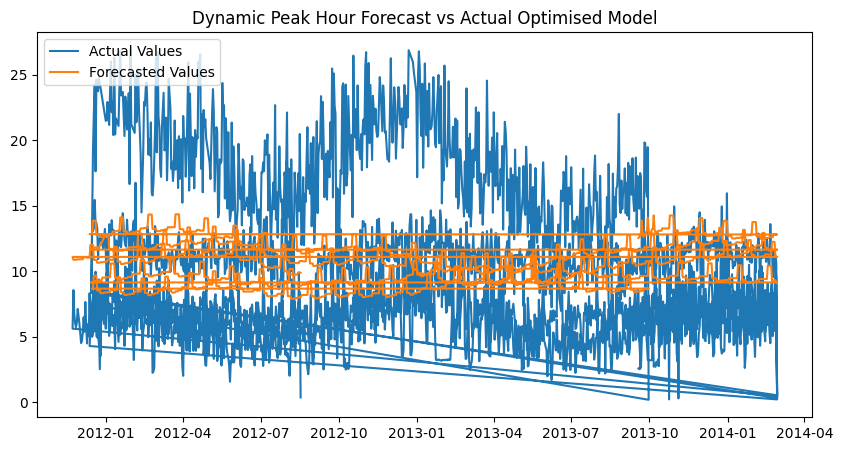

In [123]:
plt.figure(figsize=(10, 5))
plt.plot(test_data_dynamic['ds'], test_data_dynamic['y'], label='Actual Values')
plt.plot(test_data_dynamic['ds'], best_forecast_test_dynamic, label='Forecasted Values')
plt.legend(loc='upper left')
plt.title('Dynamic Peak Hour Forecast vs Actual Optimised Model')
plt.show()

In [125]:
# Using the best parameters to fit the final model
best_model_std = Prophet(
    changepoint_prior_scale=best_params['params']['changepoint_prior_scale'],
    seasonality_prior_scale=best_params['params']['seasonality_prior_scale'],
    holidays_prior_scale=best_params['params']['holidays_prior_scale'],
    yearly_seasonality=best_params['params']['yearly_seasonality']
)

best_model_std.fit(train_data_std)
best_forecast_std = best_model_std.predict(test_data_std)

# Now you can evaluate or visualize the forecast
best_forecast_test_std = best_forecast_std.iloc[-len(test_data_std):]['yhat']
mse_std_opt = mean_squared_error(test_data_std['y'], best_forecast_test_std)
mae_std_opt = mean_absolute_error(test_data_std['y'], best_forecast_test_std)
rmse_std_opt = np.sqrt(mse_std_opt)
mape_std_opt = mean_absolute_percentage_error(test_data_std['y'], best_forecast_test_std)
print(f'Mean Squared Error: {mse_std_opt}')
print(f'Mean Absolute Error: {mae_std_opt}')
print(f'Root Mean Squared Error: {rmse_std_opt}')
print(f'Mean Absolute Percentage Error: {mape_std_opt}')

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp55rp_vzb/gwisk77l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp55rp_vzb/szm1n5wk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40777', 'data', 'file=/tmp/tmp55rp_vzb/gwisk77l.json', 'init=/tmp/tmp55rp_vzb/szm1n5wk.json', 'output', 'file=/tmp/tmp55rp_vzb/prophet_modelyrswq_m3/prophet_model-20240826122341.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:23:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:23:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Mean Squared Error: 32.83398950350962
Mean Absolute Error: 3.739181723434251
Root Mean Squared Error: 5.730095069325606
Mean Absolute Percentage Error: 0.620975040811091


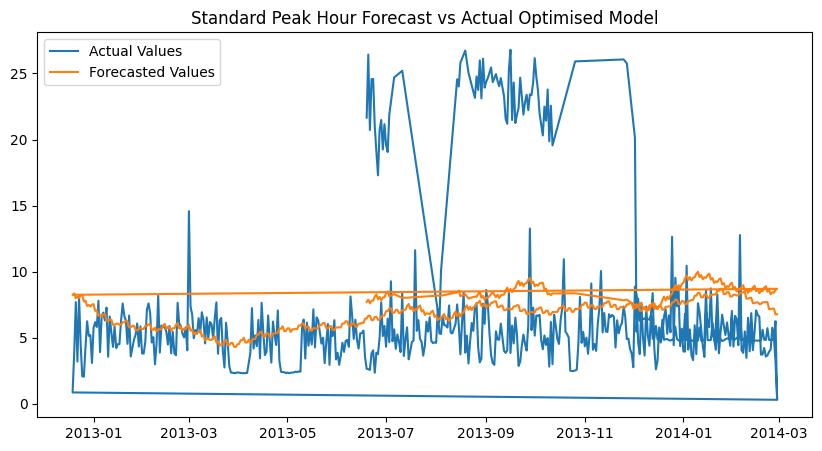

In [126]:
plt.figure(figsize=(10, 5))
plt.plot(test_data_std['ds'], test_data_std['y'], label='Actual Values')
plt.plot(test_data_std['ds'], best_forecast_test_std, label='Forecasted Values')
plt.legend(loc='upper left')
plt.title('Standard Peak Hour Forecast vs Actual Optimised Model')
plt.show()

In [127]:
# Find the maximum predicted consumption
max_predicted_value_std = best_forecast_std['yhat'].max()
max_predicted_value_dynamic = best_forecast_dynamic['yhat'].max()

# Print the results
print(f"The maximum predicted standard consumption is {max_predicted_value_std:.2f} KWH")
print(f"The maximum predicted dynamic consumption is {max_predicted_value_dynamic:.2f} KWH")

The maximum predicted standard consumption is 10.00 KWH
The maximum predicted dynamic consumption is 14.34 KWH


In [128]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
import pandas as pd

In [129]:
# Example: X and y are your features and target variables
# Assuming 'DateTime' is your index and 'KWH/hh (per half hour) ' is the target

y_dynamic = df_dynamic['Daily KWH']
X_dynamic = df_dynamic.drop(columns=['Daily KWH'])  # Use all other columns as features

# Split data into training and testing sets
X_train_dyn, X_test_dyn, y_train_dyn, y_test_dyn = train_test_split(X_dynamic, y_dynamic, test_size=0.2, random_state=42)

In [130]:
# Example: X and y are your features and target variables
# Assuming 'DateTime' is your index and 'KWH/hh (per half hour) ' is the target

y_std = df_standard['Daily KWH']
X_std = df_standard.drop(columns=['Daily KWH'])  # Use all other columns as features

# Split data into training and testing sets
X_train_std, X_test_std, y_train_std, y_test_std = train_test_split(X_std, y_std, test_size=0.2, random_state=42)

In [131]:
#Convert 'Date' to datetime object and extract relevant features
X_train_dyn['Date'] = pd.to_datetime(X_train_dyn['Date'])
X_train_dyn['Year'] = X_train_dyn['Date'].dt.year
X_train_dyn['Month'] = X_train_dyn['Date'].dt.month
X_train_dyn['Day'] = X_train_dyn['Date'].dt.day
X_train_dyn = X_train_dyn.drop(columns=['Date'])  # Drop original 'Date' column

# Convert categorical features 'stdorToU' and 'LCLid' to numerical using one-hot encoding
X_train_dyn = pd.get_dummies(X_train_dyn, columns=['stdorToU', 'LCLid'])

In [132]:
# Initialize the XGBoost regressor
xgb_dyn = xgb.XGBRegressor(objective='reg:squarederror')

# Fit the model using dynamic data
xgb_dyn.fit(X_train_dyn, y_train_dyn)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [134]:
# Convert 'Date' to datetime object and extract relevant features
X_test_dyn['Date'] = pd.to_datetime(X_test_dyn['Date'])
X_test_dyn['Year'] = X_test_dyn['Date'].dt.year
X_test_dyn['Month'] = X_test_dyn['Date'].dt.month
X_test_dyn['Day'] = X_test_dyn['Date'].dt.day
X_test_dyn = X_test_dyn.drop(columns=['Date'])  # Drop original 'Date' column

# Convert categorical features 'stdorToU' and 'LCLid' to numerical using one-hot encoding
X_test_dyn = pd.get_dummies(X_test_dyn, columns=['stdorToU', 'LCLid'])

# Predict using the trained model
y_pred_dyn = xgb_dyn.predict(X_test_dyn)

In [135]:
# Evaluate the model
mae_dynamic = mean_absolute_error(y_test_dyn, y_pred_dyn)
mse_dynamic = mean_squared_error(y_test_dyn, y_pred_dyn)
rmse_dynamic = np.sqrt(mse_dynamic)
mape_dynamic = mean_absolute_percentage_error(y_test_dyn, y_pred_dyn)

print(f"Dynamic TOU MAE: {mae_dynamic}")
print(f"Dynamic TOU MSE: {mse_dynamic}")
print(f"Dynamic TOU RMSE: {rmse_dynamic}")
print(f"Dynamic TOU MAPE: {mape_dynamic}")

Dynamic TOU MAE: 2.0453679007311374
Dynamic TOU MSE: 8.511413490304063
Dynamic TOU RMSE: 2.917432688221626
Dynamic TOU MAPE: 0.28729028482698793


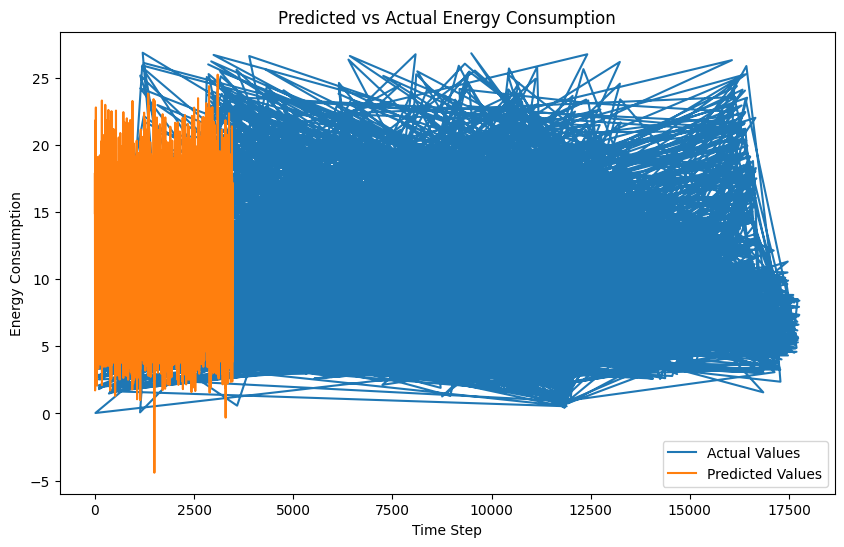

In [137]:
# Plot the predictions vs the actual values
plt.figure(figsize=(10, 6))

plt.plot(y_test_dyn, label='Actual Values')
plt.plot(y_pred_dyn, label='Predicted Values')

plt.title('Predicted vs Actual Energy Consumption')
plt.xlabel('Time Step')
plt.ylabel('Energy Consumption')
plt.legend()

plt.show()

In [149]:
# Initialize the XGBoost regressor
xgb_std = xgb.XGBRegressor(objective='reg:squarederror')

# Fit the model using dynamic data
xgb_std.fit(X_train_std, y_train_std)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [154]:
# Convert 'Date' to datetime object and extract relevant features
X_test_std['Date'] = pd.to_datetime(X_test_std['Date'])
X_test_std['Year'] = X_test_std['Date'].dt.year
X_test_std['Month'] = X_test_std['Date'].dt.month
X_test_std['Day'] = X_test_std['Date'].dt.day
X_test_std = X_test_std.drop(columns=['Date'])  # Drop original 'Date' column

# Convert categorical features 'stdorToU' and 'LCLid' to numerical using one-hot encoding
X_test_std = pd.get_dummies(X_test_std, columns=['stdorToU', 'LCLid']) # Use X_test_std instead of X_test_dyn

# Predict using the trained model
y_pred_std = xgb_std.predict(X_test_std)

KeyError: 'Date'

In [ ]:
# Evaluate the model
mae_std = mean_absolute_error(y_test_std, y_pred_std)
mse_std = mean_squared_error(y_test_std, y_pred_std)
rmse_std = np.sqrt(mse_std)
mape_std = mean_absolute_percentage_error(y_test_std, y_pred_std)

print(f"Dynamic TOU MAE: {mae_std}")
print(f"Dynamic TOU MSE: {mse_std}")
print(f"Dynamic TOU RMSE: {rmse_std}")
print(f"Dynamic TOU MAPE: {mape_std}")

In [ ]:
# Plot the predictions vs the actual values
plt.figure(figsize=(10, 6))

plt.plot(y_test_dyn, label='Actual Values')
plt.plot(y_pred_dyn, label='Predicted Values')

plt.title('Predicted vs Actual Energy Consumption')
plt.xlabel('Time Step')
plt.ylabel('Energy Consumption')
plt.legend()

plt.show()

In [138]:
# Initialize XGBoost regressor
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

In [139]:
# Initialize GridSearchCV with 5-fold cross-validation
grid_search_dynamic = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)

# Fit the grid search
grid_search_dynamic.fit(X_train_dyn, y_train_dyn)

# Get the best parameters and best model
best_params_dyn = grid_search_dynamic.best_params_
best_model_dyn = grid_search_dynamic.best_estimator_

print(f"Best Parameters Dynamic: {best_params_dyn}")

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best Parameters Dynamic: {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300, 'subsample': 0.9}


In [156]:
# Make predictions on the test set
y_pred_dyn_opt = best_model_dyn.predict(X_test_dyn)

In [157]:
mae_dynamic_opt = mean_absolute_error(y_test_dyn, y_pred_dyn_opt)
mse_dynamic_opt = mean_squared_error(y_test_dyn, y_pred_dyn_opt)
rmse_dynamic_opt = np.sqrt(mse_dynamic_opt)
mape_dynamic_opt = mean_absolute_percentage_error(y_test_dyn, y_pred_dyn_opt)

print(f"Dynamic TOU MAE: {mae_dynamic_opt}")
print(f"Dynamic TOU MSE: {mse_dynamic_opt}")
print(f"Dynamic TOU RMSE: {rmse_dynamic_opt}")
print(f"Dynamic TOU MAPE: {mape_dynamic_opt}")

Dynamic TOU MAE: 2.0492046308243452
Dynamic TOU MSE: 8.495166256313631
Dynamic TOU RMSE: 2.914646849330744
Dynamic TOU MAPE: 0.29071110499281727


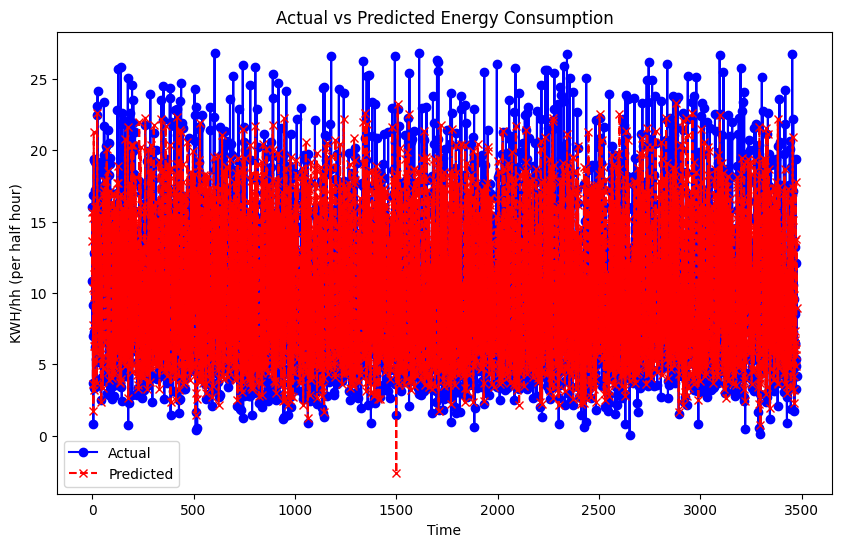

In [158]:
import matplotlib.pyplot as plt

# Create a plot
plt.figure(figsize=(10, 6))

# Plot actual values
plt.plot(y_test_dyn.values, label='Actual', color='blue', marker='o', linestyle='-')

# Plot predicted values
plt.plot(y_pred_dyn_opt, label='Predicted', color='red', marker='x', linestyle='--')

# Adding title and labels
plt.title('Actual vs Predicted Energy Consumption')
plt.xlabel('Time')
plt.ylabel('KWH/hh (per half hour)')
plt.legend()

# Display the plot
plt.show()

In [160]:
import numpy as np

# Check for NaN and infinite values in y_train_std
print("Number of NaN values in y_train_std:", y_train_std.isna().sum())
print("Number of infinite values in y_train_std:", y_train_std.isin([np.inf, -np.inf]).sum())

# If there are NaN or infinite values, you need to handle them.
# Here's one way to replace NaN values with the mean:
y_train_std = y_train_std.fillna(y_train_std.mean())
print("Number of NaN values in y_train_std:", y_train_std.isna().sum())

Number of NaN values in y_train_std: 0
Number of infinite values in y_train_std: 0
Number of NaN values in y_train_std: 0


In [161]:
# Initialize GridSearchCV with 5-fold cross-validation and error handling
grid_search_std = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1, error_score='raise') # Setting error_score='raise' will help pinpoint the exact location of the problematic values

# Fit the grid search
grid_search_std.fit(X_train_std, y_train_std)

# Get the best parameters and best model
best_params_std = grid_search_std.best_params_
best_model_std = grid_search_std.best_estimator_

print(f"Best Parameters Dynamic: {best_params_std}")


Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best Parameters Dynamic: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.9}


In [162]:
# Make predictions on the test set
y_pred_std_opt = best_model_std.predict(X_test_std)

ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, the experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:LCLid: object, stdorToU: object

In [ ]:
mae_std_opt = mean_absolute_error(y_test_std, y_pred_std_opt)
mse_std_opt = mean_squared_error(y_test_std, y_pred_std_opt)
rmse_std_opt = np.sqrt(mse_std_opt)
mape_std_opt = mean_absolute_percentage_error(y_test_std, y_pred_std_opt)

print(f"Dynamic TOU MAE: {mae_std_opt}")
print(f"Dynamic TOU MSE: {mse_std_opt}")
print(f"Dynamic TOU RMSE: {rmse_std_opt}")
print(f"Dynamic TOU MAPE: {mape_std_opt}")

In [ ]:
# Create a plot
plt.figure(figsize=(10, 6))

# Plot actual values
plt.plot(y_test_std.values, label='Actual', color='blue', marker='o', linestyle='-')

# Plot predicted values
plt.plot(y_pred_std_opt, label='Predicted', color='red', marker='x', linestyle='--')

# Adding title and labels
plt.title('Standard Actual vs Predicted Energy Consumption')
plt.xlabel('Time')
plt.ylabel('KWH/hh (per half hour)')
plt.legend()

# Display the plot
plt.show()